# [BedrockLandslider](https://landlab.readthedocs.io/en/latest/reference/components/bedrock_landslider.html)

In [1]:
import sys, time, os
from pathlib import Path
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from bmi_topography import Topography
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler, BedrockLandslider, SpaceLargeScaleEroder
from landlab.components.landslides import LandslideProbability
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask

In [2]:
# import large DEM

topo = Topography(
    dem_type="SRTMGL1",
    api_key = '1f3ea82738663688170f0d898b59ca1d',
    south=43.972829,
    north=44.013602,
    west=-123.860848,
    east=-123.795973,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

fname = topo.fetch()
dem = topo.load()
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')   

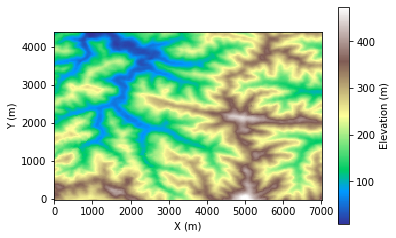

In [3]:
grid = RasterModelGrid ((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), 30) # 30 meters
grid.add_field('topographic__elevation', elev, at = 'node')

num_rows, num_columns = grid.shape 
node_spacing = grid.dx
plt.figure()
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshow_grid(grid, 'topographic__elevation',cmap =cmap,
            grid_units=("m", "m"),colorbar_label="Elevation (m)")

In [4]:
# These are plotting functions
def plotting(
    grid, topo=True, DA=True, hill_DA=False, flow_metric="D8", hill_flow_metric="Quinn"
):
    if topo:
        cmap = copy.copy(mpl.cm.get_cmap("terrain"))
        azdeg = 200
        altdeg = 20
        ve = 1
        plt.figure()
        plot_type = "DEM"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            var_name="Topo, m",
            cmap=cmap,
            plot_type=plot_type,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            default_fontsize=12,
            cbar_tick_size=10,
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )
    if DA:
        # %% Plot first instance of drainage_area
        grid.at_node["drainage_area"][grid.at_node["drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plot_DA = np.log10(grid.at_node["drainage_area"] * 111e3 * 111e3)

        plt.figure()
        plot_type = "Drape1"
        drape1 = plot_DA
        thres_drape1 = None
        alpha = 0.5
        myfile1 = "temperature.cpt"
        cmap1 = copy.copy(mpl.cm.get_cmap("terrain"))
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap=cmap1,
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=12,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=+5,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

    if hill_DA:
        # Plot second instance of drainage_area (hill_drainage_area)
        grid.at_node["hill_drainage_area"][grid.at_node["hill_drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plotDA = np.log10(grid.at_node["hill_drainage_area"] * 111e3 * 111e3)
        # plt.figure()
        # imshow_grid(grid, plotDA,grid_units=("m", "m"), var_name="Elevation (m)", cmap='terrain')

        plt.figure()
        plot_type = "Drape1"
        # plot_type='Drape2'
        drape1 = np.log10(grid.at_node["hill_drainage_area"])
        thres_drape1 = None
        alpha = 0.5
        myfile1 = "temperature.cpt"
        cmap1 = copy.copy(mpl.cm.get_cmap("terrain"))
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap=cmap1,
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=10,
            cbar_tick_size=10,
            var_name="$log^{10} DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = hill_flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

In [5]:
# here we combine the flow accumlation with the bedrock landslider 

# Here, we only calculate flow directions using the first instance of the flow accumulator
flow_metric = "D8"
fa_PF = PriorityFloodFlowRouter(
    grid,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=True,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
)

_ = grid.add_zeros('soil__depth',at='node')

#bedrock landslider
ls = BedrockLandslider(
    grid, 
    angle_int_frict= .5, #84 should be correct for a 40 degree value but using what is in original
    landslides_return_time=1e3,
    cohesion_eff = 1e3,)


In [6]:
timestep = 50.0
elapsed_time = 0.0
count = 0
run_time = 1e3
#sed_flux = np.zeros(int(run_time // timestep))

while elapsed_time < run_time:
    # run the bedrock landslide
    fa_PF.run_one_step()
    ls.run_one_step(dt=timestep)
    elapsed_time += timestep

/opt/tljh/user/envs/ivy/lib/python3.9/site-packages/landlab/components/bedrock_landslider/bedrock_landslider.py:647: RuntimeWarning: divide by zero encountered in true_divide
  self.grid.dx / (1 - (slope / self._angle_int_frict) ** 2),


In [7]:
#original code commenting out to run cell above
# fa_PF.run_one_step()
# ls.run_one_step(dt=50)


# # Plot output products
# plotting(grid, hill_DA=True)

Text(0, 0.5, 'Landslide frequency')

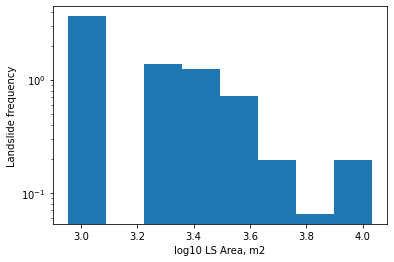

In [8]:

plt.figure()
LS_size = np.array(ls.landslides_size) * grid.dx ** 2
counts, bins = np.histogram(np.log10(LS_size), 8)
plt.hist(np.log10(LS_size), log=True, bins=bins, density=True)
# counts, bins = np.histogram(LS_size, 10)
# plt.hist(LS_size, bins=bins)
plt.xlabel("log10 LS Area, m2")
plt.ylabel("Landslide frequency")

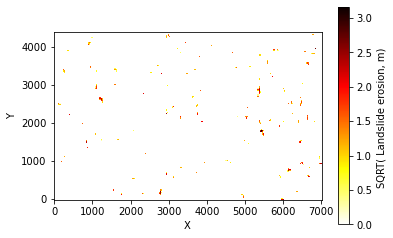

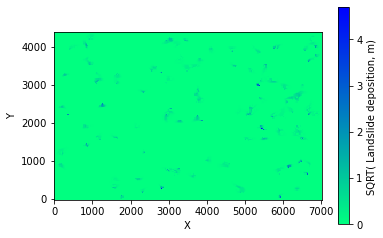

In [9]:
# Landslide Erosion 
cmap = copy.copy(mpl.cm.get_cmap("hot_r"))
imshow_grid(grid,np.sqrt(grid.at_node["landslide__erosion"]), colorbar_label = 'SQRT( Landslide erosion, m) ',cmap =cmap)
plt.show()

# Landslide Deposition 
cmap = copy.copy(mpl.cm.get_cmap("winter_r"))
imshow_grid(grid,np.sqrt(grid.at_node["landslide__deposition"]), colorbar_label = 'SQRT( Landslide deposition, m) ',cmap =cmap)
plt.show()


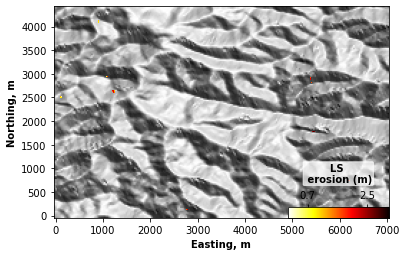

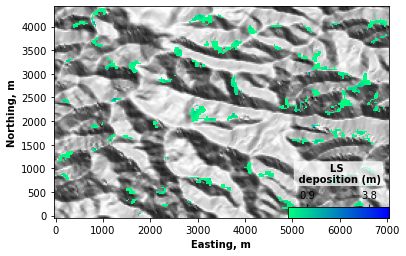

In [10]:
# Show Landslide Erosion draped over the shaded topographic relief
cmap1 = copy.copy(mpl.cm.get_cmap("hot_r"))
imshowhs_grid(
    grid,
    "topographic__elevation",
    drape1=np.sqrt(grid.at_node["landslide__erosion"]),
    plot_type="Drape1",
    var_name="LS \n erosion",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap1,
    ticks_km=False,
    colorbar_label_y=-55,
    add_label_bbox=True,
    thres_drape1=.01,
)
plt.show()
# Show Landslide deposition draped over the shaded topographic relief
cmap1 = copy.copy(mpl.cm.get_cmap("winter_r"))
imshowhs_grid(
    grid,
    "topographic__elevation",
    drape1=np.sqrt(grid.at_node["landslide__deposition"]),
    plot_type="Drape1",
    var_name="LS \n deposition",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap1,
    ticks_km=False,
    colorbar_label_y=-55,
    add_label_bbox=True,
    thres_drape1=0.01,
)
plt.show()



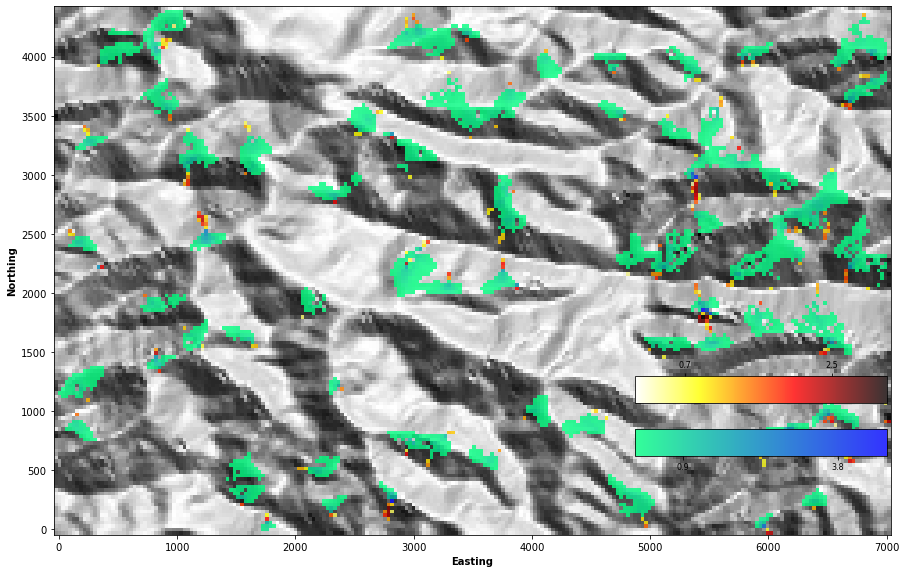

In [11]:
# Show Landslide erosion and deposition draped over the shaded topographic relief
cmap1 = copy.copy(mpl.cm.get_cmap("Blues"))
thres_drape1=0.01
thres_drape2=0.01
alpha  = .8
alpha2 = .8
drape1 = np.sqrt(grid.at_node["landslide__erosion"])
drape2 = np.sqrt(grid.at_node["landslide__deposition"])
cmap1 = copy.copy(mpl.cm.get_cmap("hot_r"))
cmap2 = copy.copy(mpl.cm.get_cmap("winter_r"))
plt.figure(figsize=(15,15))
imshowhs_grid(grid, "topographic__elevation",
              plot_type='Drape2',         
              drape1 = drape1,
              cmap=cmap1,
              thres_drape1=thres_drape1,
              alpha=alpha,
              drape2 = drape2,
              cmap2=cmap2,
              thres_drape2=thres_drape2,
              alpha2=alpha2,
              add_double_colorbar=True, 
              cbar_tick_size =8,
              cbar_label_color='red',
              cbar_label_fontweight = 'normal',
              add_label_bbox = True, )
                
plt.show()

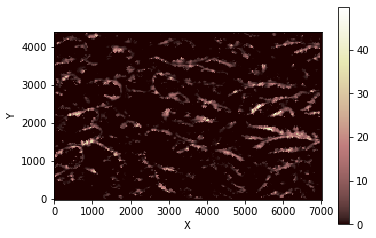

In [12]:
imshow_grid(grid, 'soil__depth')

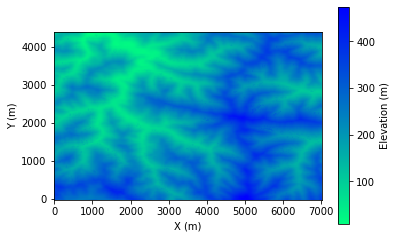

In [13]:
imshow_grid(grid, 'topographic__elevation',cmap =cmap,
            grid_units=("m", "m"),colorbar_label="Elevation (m)")